# Vortex Ballistics- Image Treatment Algorithm

#### This code is used to treat the images acquired from the vortex ballistics program. To use the program follow the steps below and then go to cell -> run all to run all the cells in this noteook
##### User Inputs
- filename: (STRING) the user should set the full path to the file name. Ensure that it starts with something similar to W:// or C:// etc and ends with .JPG or .PNG, etc. Put the entire filename in quotes before passing it into the variable
- samplingRate: (INTEGER) the user should adjust this value to represent how many times per degree the thickness of the frost pattern is sampled. 1 indicates at every degree while 4 indicates that each degree is sampled at, for example, 90, 90.25, 90.5, 90.75, 91, etc
- fullOverlay: (BOOLEAN) the user should enter either True or False for their needs. When overlaying the graph over the original image, the graph is rescaled based on the distance from the center point to the closest edge. 
    --> If FALSE is selected, then the graph is overlayed as a rectangle with the length described above and centered at the central point. This creates an overlay half the size of the fixture and the graph generally fits within the inner circle in the middle of the fixture (assuming that fixture version 6 is being used). 
    --> If TRUE is selected, then the graph is overlayed as a rectangle with twice the length described above and centered at the central point. This creates an overlay that is approximately the full height of the fixture and the graph generally circumvents the frosted region which we are attempting to analyze (assuming that fixture version 6 is being used)
- scaleFactor: (DOUBLE between 0-2) a very similar parameter as described above. However, this parameter allows for more flexibility in resizing. Essentially, the scale factor is multiplied by the distance from the center point to the closest edge. So 1 indicates that the length's are equal (same effect as setting False in full overlay), 2 indicates that the length of the overlay is double and 0 indicates no length. Any value between these can be selected and this will allow for further resizing to what the user prefers. (this is currently commented out, but can be uncommented to allow for this capability)

##### Outputs
- an overlay (in green) over the original image which shows the region which the computer selected as the region of interest over the original image as a check to ensure that it was correctly recognized
- graph of thickness (in pixels) in the form of linear plot from 0-360 going counterclockwise around the frost pattern
- graph of thickness (in pixels) in the form of a radial plot from 0-360 going counterclockwise around the frost pattern
- an overlay of the radial graph over the original image
- an overlay of the radial graph over the original image with the green overlay

##### Instructions for Use
1. Ensure that all the relevant inputs stated in the User Inputs section have been accurately filled out
2. Go to the drop down menus and select cell --> run all
3. Two pop up windows will appear: one with the original gel image and one with a black background
4. Press 1 on your keyboard and navigate to the image with gel image.
5. Click on the regions which are not of interest for our study. Click in the inner circle within the frost and click outside the forst
6. Press 2 on your keyboard
7. Click on the regions of the frost image which we wish to study. 
8. Check the black image which should now have the regions that you have selected. If the algorithm has selected more of the frost than intended select 1 again and manually remove the areas which we do not wish to analyze
9. Click the 's' button on your keyboard to save the image
10. Click the 'Esc' button on your keyboard to exit the image viewer screen (the code WILL break if you attempt to close manually)
11. The rest of the code will run automatically. If more overlay images want to be seen, use the plot_overlay function

##### Further Instructions
This program has generally been intended for the purpose of the vortex ballistics image analysis. However, the code has been approximately 95% generalized so that any image can be analyzed. The image viewer screen has the capability of segmenting up to 10 different regions within and image, but this code only works with 2 for now. If help is required generalizing this code for another purpose, reach out to Nevin_Aresh@steris.com.

In [ ]:
import numpy as np
import skimage as ski
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, data
import cv2
from PIL import Image
import math
import skimage.morphology as morph
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from matplotlib import cm
from statistics import mean 
from scipy.interpolate import make_interp_spline
import random

In [ ]:
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\IMG_0470.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\8-3-23 - Warm 0.75 Frost.JPG"
filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Original Images 2\IMG_0470.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\8-3-23 - White Full Frost.JPG"
#filename = "W:\Advanced Engineering/Vortex Ballistics/Gel Images/NR Image.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0489.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0491.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0493.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0495.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00648.JPG"
gelImg = cv2.imread(filename)
fixLength = 34 #Dimension in x-axis
fixHeight = 30 #Dimension in y-axis
dimDiff = fixLength-fixHeight
name = filename.split('\\')[-1][:-4]

### Image Reading and Pre-Processing

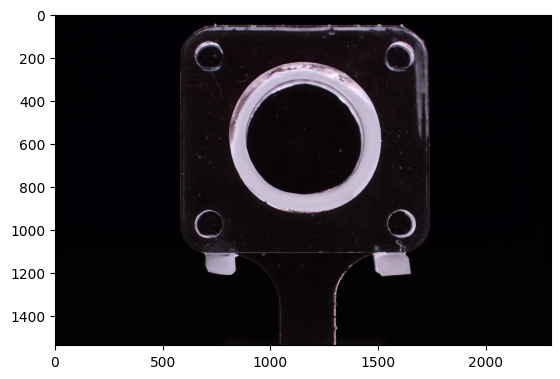

In [ ]:
#Reads in the image selected and resized the image so that it can fit on the screen
#Change the / in gelImage to either have a larger or smaller image
resizeFactor = 4
gelImg = cv2.imread(filename)
#gelImg = cv2.resize(gelImg, (int(gelImg.shape[1]/9), int(gelImg.shape[0]/9)))
gelImg = cv2.resize(gelImg, (int(576*resizeFactor), int(384*resizeFactor)))
gelImg_copy = np.copy(gelImg)
plt.imshow(gelImg)

In [ ]:
#creating an image that the watershed algorithm uses to determine the foreground
#this is currently just a black image of the same size
marker_image = np.zeros(gelImg.shape[:2], dtype=np.int32)
segments = np.zeros(gelImg.shape, dtype=np.uint8)

In [ ]:
#pick color map for different seeds based on tab10
#allows for 10 different colors, but segmentation code will only perform accurately for 2 colors
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

In [ ]:
#creating a color array with all possible colors for the user to chose from
colors = []
for i in range(10):
    colors.append(create_rgb(i))

### Watershed Segmentation of the Image

In [ ]:
#global variables that are used in the function of watershed
#always start with marker1, last Marker indicates the last marker used 
#markers_updates shows whether the marker has changed from its initial state
#n_markers is num of possible markers
#copy the markerimg and the gelimg to not lose important information
#GlOBAL VARIABLES
current_marker = 1
lastMarker = 1
marks_updated = False
n_markers = 10
lastMarkerImg = marker_image.copy()
lastGelImg = gelImg_copy.copy()

In [ ]:
#creates a function that indicates what should be done when the left mouse button is clicked
#passes the clicked foreground circle to the markers as the foreground
#displays the circle on the gelCopy to see where it was placed
#changes the marksUpdated to true

#CALLBACK FUNCTION
def mouse_callback(event, x, y, flags, param):
    global marks_updated
    global lastGelImg
    global lastMarkerImg
    
    if event == cv2.EVENT_LBUTTONDOWN:
        lastGelImg = np.copy(gelImg_copy)
        lastMarkerImg = np.copy(marker_image)
        #circle passed to watershed
        cv2.circle(marker_image, (x,y), 2*resizeFactor, (current_marker), -1)
        
        #user visual
        cv2.circle(gelImg_copy, (x,y), 2*resizeFactor, colors[current_marker], -1)
        
        marks_updated = True

In [ ]:
#initializing and setting variables
gelImg_copy = gelImg.copy()
marker_image = np.zeros(gelImg.shape[:2], dtype=np.int32)
segments = np.zeros(gelImg.shape, dtype=np.uint8)
lastMarkerImg = marker_image.copy()
lastGelImg = gelImg.copy()

#creates the display windows
cv2.namedWindow('Gel Image', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('Gel Image', mouse_callback)
cv2.resizeWindow("Gel Image", 576, 384) 

cv2.namedWindow('Watershed Segments', cv2.WINDOW_NORMAL)
cv2.resizeWindow("Watershed Segments", 576, 384) 

#runs until the 'esc' key is pressed
while True:
    cv2.imshow('Watershed Segments', segments)
    cv2.imshow('Gel Image', gelImg_copy)
    
    #k is the key that is pressed
    k = cv2.waitKey(1)
    
    #if esc is pressed save the current image to variable for further processing and exit loop
    if k == 27:
        outImg = segments.copy()
        break
     
    #clear all markers placed if 'c' is qpressed on all 3 images
    elif k == ord('c'):
        gelImg_copy = gelImg.copy()
        marker_image = np.zeros(gelImg.shape[:2], dtype = np.int32)
        segments = np.zeros(gelImg.shape, dtype=np.uint8)
    
    #Update Color Choice depending on which digit is pressed
    elif k> 0 and chr(k).isdigit():
        lastMarker = current_marker
        current_marker = int(chr(k))
        
    #save the image to outImg when 's' is pressed
    elif k == ord('s'):
        outImg = segments.copy()

    elif k == ord('q'):
        cv2.destroyAllWindows()
        raise ValueError("Exited code")
        
    #if backspace is pressed removes the last marker and goes back exactly one step
    #for further backspace capability as stack can be immplemented which states all the transforms that have been done
    #can then pop from the stack to remove the last known marker and go back as much as you want
    #we have clear capability instead of backspacing multiple times
    elif k == 8:
        gelImg_copy = lastGelImg
        marker_image = lastMarkerImg
        
        #rewatershed with all markers except for the final one
        marker_image_copy = marker_image.copy()
        cv2.watershed(gelImg, marker_image_copy)
        
        #creates black background again
        segments = np.zeros(gelImg.shape, dtype=np.uint8)
        
        #draws all the markers except for the last one
        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]
        
    #updates the marks on the acual image and uses watershed to draw the seperated segments on the segments image
    if marks_updated:
        marker_image_copy = marker_image.copy()
        cv2.watershed(gelImg, marker_image_copy)
        
        #creates black background again
        segments = np.zeros(gelImg.shape, dtype=np.uint8)
        
        #draws all the markers except for the last one
        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]

#destroys all windows so that the program doesn't crash
cv2.destroyAllWindows()

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'resizeWindow'
> Overload resolution failed:
>  - Argument 'width' is required to be an integer
>  - resizeWindow() takes at most 2 arguments (3 given)


: 

### Post-processing of the resulting Watershed Segmented Images

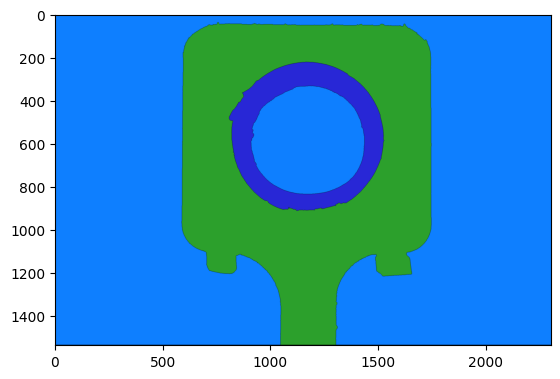

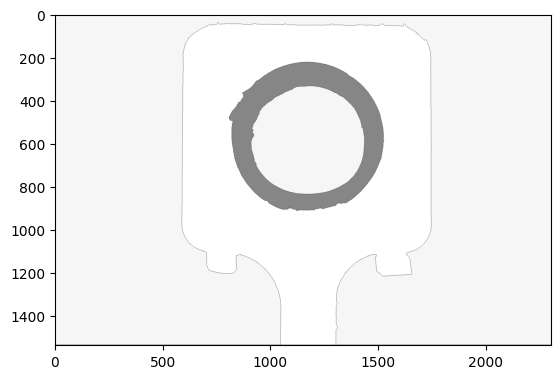

In [ ]:
#outputs the image from the watershed window from above and also the grayscale version

outImg = cv2.cvtColor(outImg, cv2.COLOR_BGR2RGB)
plt.imshow(outImg)
plt.show()
grayOut = cv2.cvtColor(outImg, cv2.COLOR_RGB2GRAY)
plt.imshow(grayOut, cmap='gray')
plt.imshow(grayOut, cmap = 'gray')

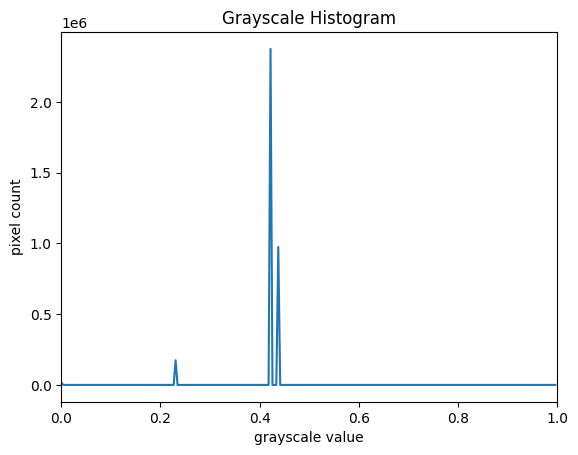

In [ ]:
#uses a histogram to plot all the hues on the gray image from above
histoGray = ski.util.img_as_float(grayOut)
histogram, bin_edges = np.histogram(histoGray, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])

plt.plot(bin_edges[0:-1], histogram)

[  16078  174072 2373944  974850]


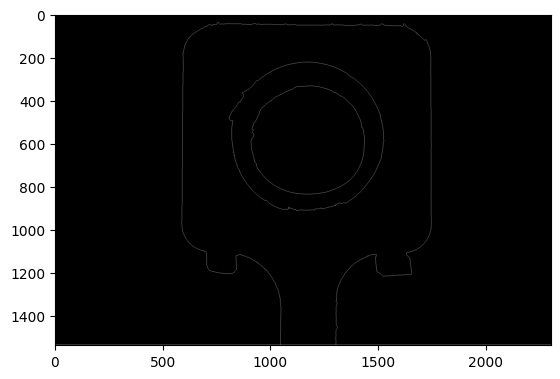

In [ ]:
#uses the pixel count from the histogram to determine the pixel value and the incidence
vals, counts = np.unique(histoGray, return_counts = True)
print(counts)

#creates a mask for the border (which is in pure black) since we want the border included in the final parsed image
borderMask = np.zeros(grayOut.shape)
borderMask[histoGray == 0] = 255
plt.imshow(borderMask, cmap='gray')

974850
[  16078  174072 2373944  974850]
3
112


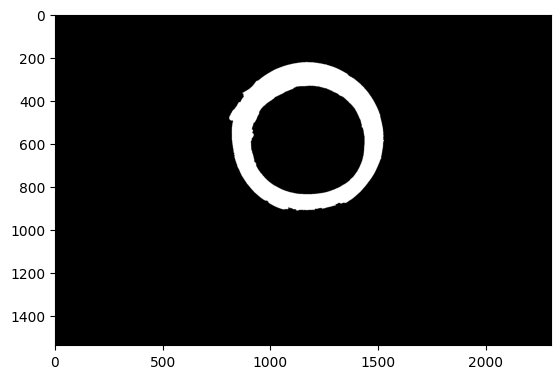

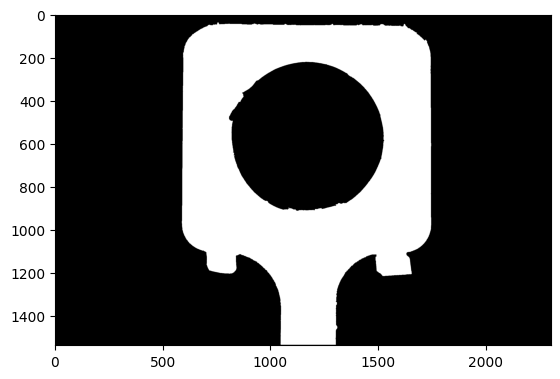

In [ ]:
#uses the frequency data from the histogram to determine whether the inner circle is the lighter or darker shade of gray
#then accurately thresholds based on that information so that the ring is always white and the backgound is black
#the midPix is used to determine a value between the two to threshold
# tempCounts = counts.copy()
# print(tempCounts)
# tempCounts.sort()
# ringCount = tempCounts[1]
tempCounts = counts.copy()
tempCounts = tempCounts[1:]
ringCount = tempCounts.min()
ringInd = np.where(counts == ringCount)[0][0]
pixValRing = round(vals[ringInd]*255)
#threshRing = cv2.threshold(grayOut, pixValRing-2, pixValRing+2, cv2.THRESH_BINARY)[1]
threshRing = cv2.inRange(grayOut, pixValRing-2, pixValRing+2)

fixCount = tempCounts[2]
print(fixCount)
print(counts)
fixInd = np.where(counts == fixCount)[0][0]
print(fixInd)
pixValFix = round(vals[fixInd]*255)
print(pixValFix)
#threshFix = cv2.threshold(grayOut, pixValFix-3, pixValFix-3, cv2.THRESH_BINARY)[1]
threshFix = cv2.inRange(grayOut, pixValFix-2, pixValFix+2)


# midPix = round(mean([vals[1], vals[2]])*255)
# print(midPix)
# if counts[1] > counts[2]:
#     thresh = cv2.threshold(grayOut, midPix, 255, cv2.THRESH_BINARY)[1]
# else: 
#     thresh = cv2.threshold(grayOut, midPix, 255, cv2.THRESH_BINARY_INV)[1]
#plt.imshow(threshRing, cmap='gray')
#plt.show()
#thresh = np.zeros(histoGray.shape)

#copies the thresh into a variable called fullThick
fullThick = threshRing.copy()
#fullThick[borderMask == 255] = 255
plt.imshow(fullThick, cmap='gray')
plt.show()

fixture = threshFix.copy()
plt.imshow(fixture, cmap='gray')
plt.show()

In [ ]:
## calculate ratio of pixels to fixture length
pixWidth = max(fixture.sum(axis=1)) / 255
mm2pix = fixLength/pixWidth
mm2pix

0.029411764705882353

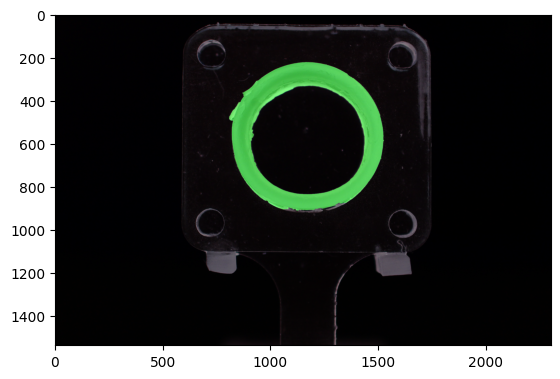

In [ ]:
#uses the mask from fullThick on a green background to color the area that the algorithm picked up as green
#overlays the green image over the original so that one can do a sanity check that it picked up the right information

greenBack = np.full(gelImg.shape, 0, dtype=np.uint8)
greenBack[:,:,1] = 255
freezeGreen = cv2.bitwise_or(greenBack, greenBack, mask=fullThick)
overlay = cv2.addWeighted(gelImg, 0.5, freezeGreen, 0.5, gamma = 0)
plt.imshow(overlay)

### Finding the Center of the Frost Image

In [ ]:
#determining the various shapes within the fullThick image by using contours and the hierarchy

contours, hierarchy = cv2.findContours(fullThick, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarchy

array([[[-1, -1,  1, -1],
        [-1, -1, -1,  0]]], dtype=int32)

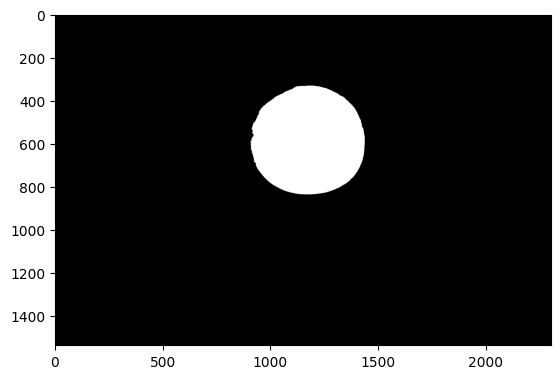

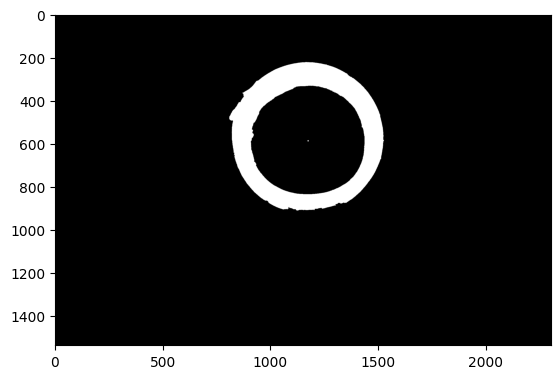

In [ ]:
#creates a black image that is 
inCircle = np.zeros(fullThick.shape)

for i in range(len(contours)):
    #hard-coded. If the image ever changes or the code is repurposed for something else this needs to change
    #this is used to find the center and with the current fixture the central circle is always hierarchy order #2
    # if the center of another portion needs to be found, then change the value down below
    if hierarchy[0][i][3] == 0:
        cv2.drawContours(inCircle, contours,i,255,-1)
        
plt.imshow(inCircle, cmap='gray')
plt.show()

#uses the inner circle to calculate the centroid
#since the circle isn't perfect using the method of centroid to find the center
#calculates the moment of every point in the center to calculate cX and cY

M = cv2.moments(inCircle)
#print(M)

fullThickCenter = fullThick.copy()
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

#Display the calculated centroid on the black and white fullThick image
cv2.circle(fullThickCenter, (cX, cY), 3, 255, -1)
plt.imshow(fullThickCenter, cmap = 'gray')

### Finding the Radial Thickness of Frost Pattern

In [ ]:
#change this line to change how often we are sampling within each degree
#To sample every degree, change sampling rate to 1. 4 times per degree would be at 0, 0.25, 0.5, 0.75, 1, etc 
#The smaller the sampling rate, the faster the code runs. This is the only time consuming part of the code
#This can be fine tuned for level of detail required in the plots
samplingRate = 3

#fullThick1 = fullThick.copy()
#fullThick1 = cv2.resize(gelImg, (576, 384))


#calculates the minimum distance from the center point to the edges of the image
#makes this the radius of the circle we are sampling
distCenter = [cX, cY, fullThickCenter.shape[0] - cY, fullThickCenter.shape[1] - cX]
maxRad = min(distCenter)

#lets us know if the shortest distance is in the x or y direction which is important later on
if distCenter.index(maxRad) == 0 or distCenter.index(maxRad) == 3:
    xShort = True
else:
    xShort = False

startX = cX
startY = cY
lineLength = maxRad

thicknessProfile = []

#i is the degree at which we are sampling
#essentially draws a white line of length maxRad from the center in the degree specified on a black background
#looks at the intersection of the white line with the white ring to see where there is overlap
#Calculates thickness by taking the # pixels in the overlap section and dividing by the # pixels in the full line
#multiplies this ratio by the pixel length to get straight thickness of the image
#adds a tuple of the degree and the length to an array called thicknessProfile. Repeats for all degrees
timeArrFull = []

for j in range(360*samplingRate):
    timeArrPart = []
    i = j/samplingRate
    lineMask = np.zeros(fullThick.shape)
    endX = math.floor(cX + math.cos(math.radians(i))*lineLength)
    endY = math.floor(cY + math.sin(math.radians(i))*lineLength)
    cv2.line(lineMask, (startX, startY), (endX, endY), 255, 3)
    currSlice = (fullThick != 0) & (lineMask != 0)
    count = (np.count_nonzero(currSlice) / np.count_nonzero(lineMask)) * maxRad
    thicknessProfile.append((i,count))

In [ ]:
#prints the distances to each of the edges from the center
[cX, cY, fullThickCenter.shape[0] - cY, fullThickCenter.shape[1] - cX]

[1173, 588, 948, 1131]

### Graphing and Outputting the Thickness Data Collected

In [ ]:
#unpacks the tuple array into x and y
#when sampling degrees, the line moves clockwise, while it is customary to unit circle in counter-clockwise direction
#therefore had to reverse the entire list of y-values so it is consistent with the unit circle schematic
x, y = zip(*thicknessProfile)
x = np.array(x)
y = np.array(y)
y = np.flip(y)*mm2pix

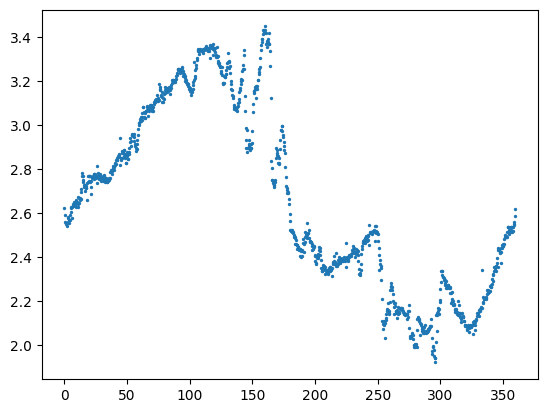

In [ ]:
#scatterplot of the thickness vs degrees
plt.scatter(x,y, s=2)

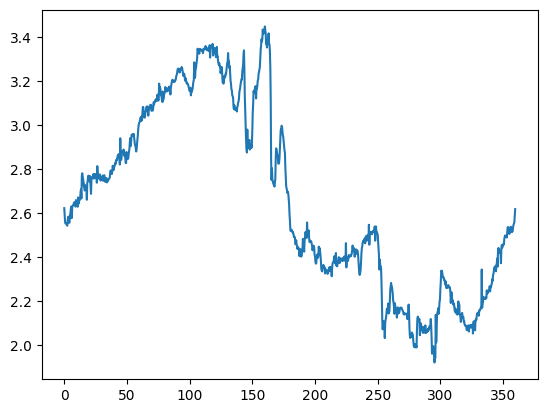

In [ ]:
#lineplot of the thickness vs degrees
plt.plot(x,y)

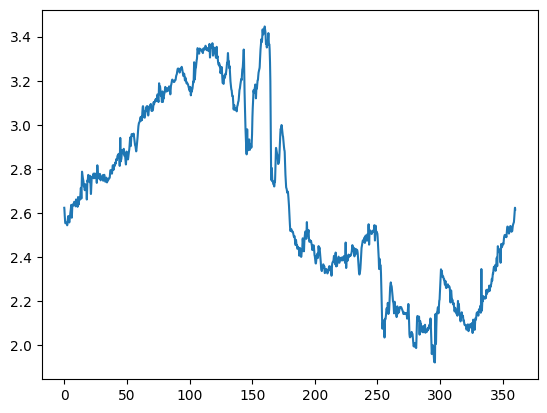

In [ ]:
#smoothed lineplot of thickness vs degrees by interpolating 250 times between each point
#this shouldn't change much unless you're sampling at a rate less than .5
X_Y_Spline = make_interp_spline(x,y)
X_ = np.linspace(0, 360, 360*samplingRate*250)
Y_ = X_Y_Spline(X_)
plt.plot(X_, Y_)

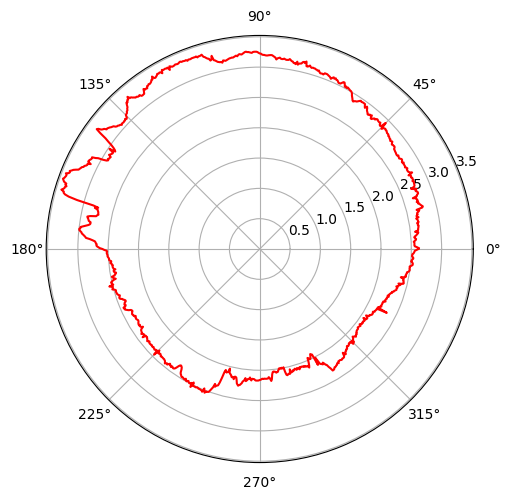

In [ ]:
#converts the values to a radial plot and graphs it on a red line
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.tight_layout(pad=0)
x, y = zip(*thicknessProfile)
x = np.array(x)
y = np.array(y)*mm2pix
x = 360-x
rads = x.astype('float') * np.pi/180
ax.plot(rads, y, color='red')
plt.show()
fig.canvas.draw()

C:\Users\naresh\AppData\Local\Temp\ipykernel_25120\2475854808.py:13: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


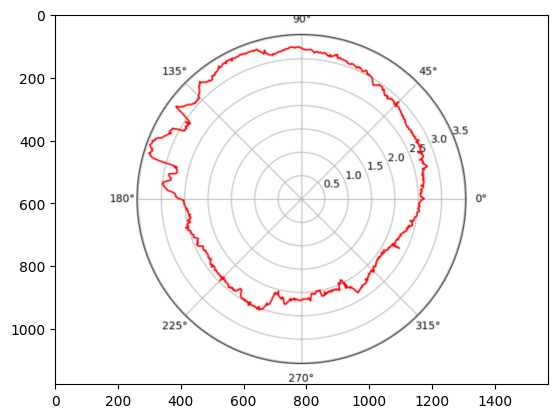

In [ ]:
#If TRUE, the graph will be places to that it takes the area from the center to the closest edge (MAX POSS SIZE)
#If False, the image is half the size of the distance to the closest edge
fullOverlay = True

#UNCOMMENT THE 3# LINES BELOW DEPENDING
#number from 0-2 that indicates how big the overlayed graph should be
#0 means no graph
#1 is the half size (equivalent of selecting False above)
#2 is max size (equivalent of selecting True above)
###scaleFactor = 1

#takes the graph from above and converts it to an image which is then used to overlay ontop of the original gel image
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
w, h = fig.canvas.get_width_height()
im = data.reshape((int(h), int(w), -1))
if fullOverlay:
    if xShort:
        ratio = maxRad*2/w
        graphPic = cv2.resize(im, (maxRad*2, int(ratio*int(h))))
    else:
        ratio = maxRad*2/h
        graphPic = cv2.resize(im, (int(ratio*w), maxRad*2)) 
else:
    if xShort:
        ratio = maxRad/w
        graphPic = cv2.resize(im, (maxRad, int(ratio*int(h))))
    else:
        ratio = maxRad/h
        graphPic = cv2.resize(im, (int(ratio*w), maxRad))

### if xShort:
###     ratio = maxRad*scaleFactor/w
###     graphPic = cv2.resize(im, (maxRad*scaleFactor, int(ratio*int(h))))
### else:
###     ratio = maxRad*scaleFactor/h
###     graphPic = cv2.resize(im, (int(ratio*w), maxRad*scaleFactor))       

plt.imshow(graphPic)

In [ ]:
graphPic.shape

(1176, 1568, 3)

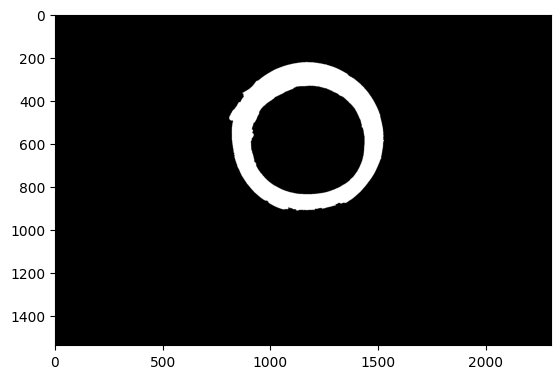

In [ ]:
plt.imshow(fullThick, cmap='gray')

In [ ]:
#function that takes two COLOR IMAGES (will break if images are not colored with RGB channels)
#overlays the image called fore over the image called back by overlaying the center of back on the centroid of the image
#should just be used for any background image and the graph foreground image
### inputs: the background image, foreground image(ONLY the graph)
### returns: background image with overlayed image, the portion of the background image where the fore was placed (roi)
def plot_overlay(back, fore):
    #calculates the section of the background where the foreground image is going to be placed
    #this is done with the centroid and the length and width of the foreground image
    xOff = cX - int(fore.shape[1]/2)
    yOff = cY - int(fore.shape[0]/2)
    roi = back[yOff:yOff+fore.shape[0], xOff:xOff+fore.shape[1]]

    #converts the graph to a black and white copy. This part is hard coded because we know that the background is white
    #and anything that is non-white must belong to the graph
    #for other images, this threshold needs to be changed especially if this code is used for something than what is stated above
    back2gray = cv2.cvtColor(fore, cv2.COLOR_RGB2GRAY)
    back2gray = cv2.threshold(back2gray, 245, 255, cv2.THRESH_BINARY)[1]
    maskBack = cv2.bitwise_not(back2gray)
    whiteBack = np.full(fore.shape, 255, dtype=np.uint8)
    bk = cv2.bitwise_or(whiteBack, whiteBack, mask = maskBack)

    #uses the mask from above to place the foreground over hte background in the region of interest
    fg = cv2.bitwise_or(fore, fore, mask=maskBack)
    finalRoi =  cv2.bitwise_or(roi, fg)

    #replaces the region of interest in the original image with the updated one 
    back[yOff:yOff+fore.shape[0], xOff:xOff+fore.shape[1]] = finalRoi
    back = cv2.resize(back, (back.shape[1]*2, back.shape[0]*2))
    return back, finalRoi

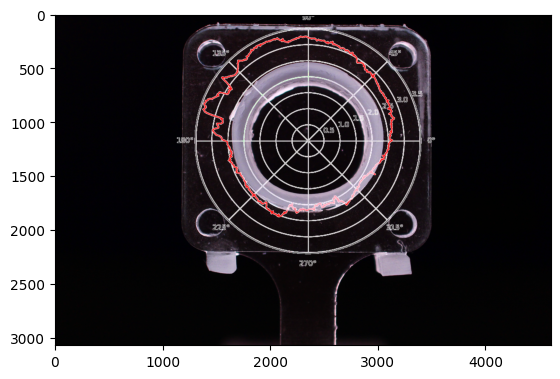

In [ ]:
#plot the radial plot graph over the gel image
fullReg, section = plot_overlay(gelImg.copy(), graphPic.copy())
plt.imshow(fullReg)

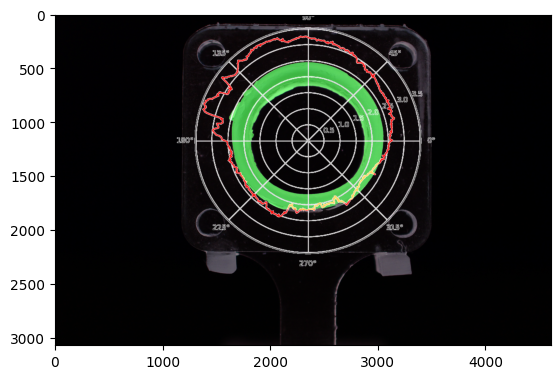

In [ ]:
#plot the radial plot graph over the gel image with the green area representing what was analyzed
fullGreen, section = plot_overlay(overlay.copy(), graphPic.copy())
plt.imshow(fullGreen)

### Saving the Images to Directory

In [ ]:
def train_or_test():
    num = np.random.rand()
    if num < 0.8:
        imageDir = '/05- train- Big Img'
    else:
        imageDir = '/06- test- Big Img'
    return imageDir

print(name)

IMG_0469


In [ ]:
generalFilePath = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training"

# inputDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Input Images"
# watershedDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Watershed Output"
# graphDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Graph Output"
# overlayDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Overlay Output"
# origGraphDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Original Image + Graph Output"
# greenGraphDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Overlay Image + Graph Output"
# ringMaskDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Ring Mask"
# fixMaskDir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Fixture Mask"

inputDir = "/Input/img"
#watershedDir = "/Watershed Out/img"
#graphDir = "/Graph Out/img"
#overlayDir = "/Overlay Out/img"
#origGraphDir = "/Original Image + Graph Output/img"
#greenGraphDir = "/Green Image + Graph Output/img"
ringMaskDir = "/Ring Mask/img"
fixMaskDir = "/Fixture Mask/img"

In [ ]:
origImg = gelImg
watershedImg = outImg
graph = graphPic
overlayImg = overlay
overlayImgReg = fullReg
overlayImgGreen = fullGreen
ringMask = threshRing
fixMask = threshFix

In [ ]:
#save original
imageDir = train_or_test()
# cv2.imwrite(inputDir + "\\" + name + '.jpg', origImg)
# cv2.imwrite(watershedDir + "\\" + name + '.jpg', watershedImg)
# cv2.imwrite(graphDir + "\\" + name + '.jpg', graph)
# cv2.imwrite(overlayDir + "\\" + name + '.jpg', overlayImg)
# cv2.imwrite(origGraphDir + "\\" + name + '.jpg', overlayImgReg)
# cv2.imwrite(greenGraphDir + "\\" + name + '.jpg', overlayImgGreen)
# cv2.imwrite(ringMaskDir + "\\" + name + '.jpg', ringMask)
# cv2.imwrite(fixMaskDir + "\\" + name + '.jpg', fixMask)
cv2.imwrite(generalFilePath + imageDir + inputDir + '/' + name + '.jpg', origImg)
# cv2.imwrite(generalFilePath + imageDir + watershedDir + '/' + name + '.jpg', watershedImg)
# cv2.imwrite(generalFilePath + imageDir + graphDir + '/' + name + '.jpg', graph)
# cv2.imwrite(generalFilePath + imageDir + overlayDir + '/' + name + '.jpg', overlayImg)
# cv2.imwrite(generalFilePath + imageDir + origGraphDir + '/' + name + '.jpg', overlayImgReg)
# cv2.imwrite(generalFilePath + imageDir + greenGraphDir + '/' + name + '.jpg', overlayImgGreen)
cv2.imwrite(generalFilePath + imageDir + ringMaskDir + '/' + name + '.jpg', ringMask)
cv2.imwrite(generalFilePath + imageDir + fixMaskDir + '/' + name + '.jpg', fixMask)

True

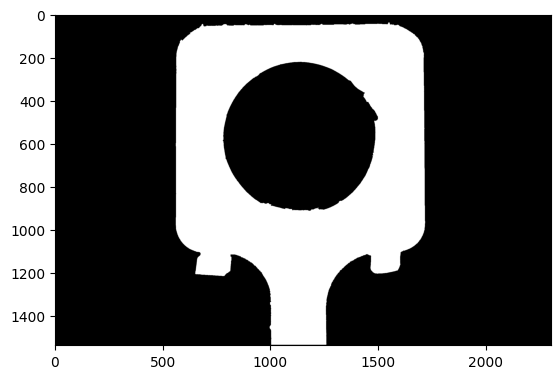

In [ ]:
plt.imshow(cv2.flip(fixMask,1), cmap='gray')